# Quantile Regression with Different Algorithms

Fit quantiles of a non-linear 1D function using ensembles different model algorithms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scst

from genestboost import BoostedModel
from genestboost.link_functions import IdentityLink
from genestboost.loss_functions import QuantileLoss

%matplotlib inline

### Create a Random Function and Generate Data Points

Below, 5000 points are generated according to the following function specification:

$$ f(x) = (5.0 \cdot sin(x) + 7.5) \cdot \epsilon $$
$$ \epsilon = lognormal \left( 0.0, \frac{1.0}{(x - 4.0)^2 + 4.0} \right) $$

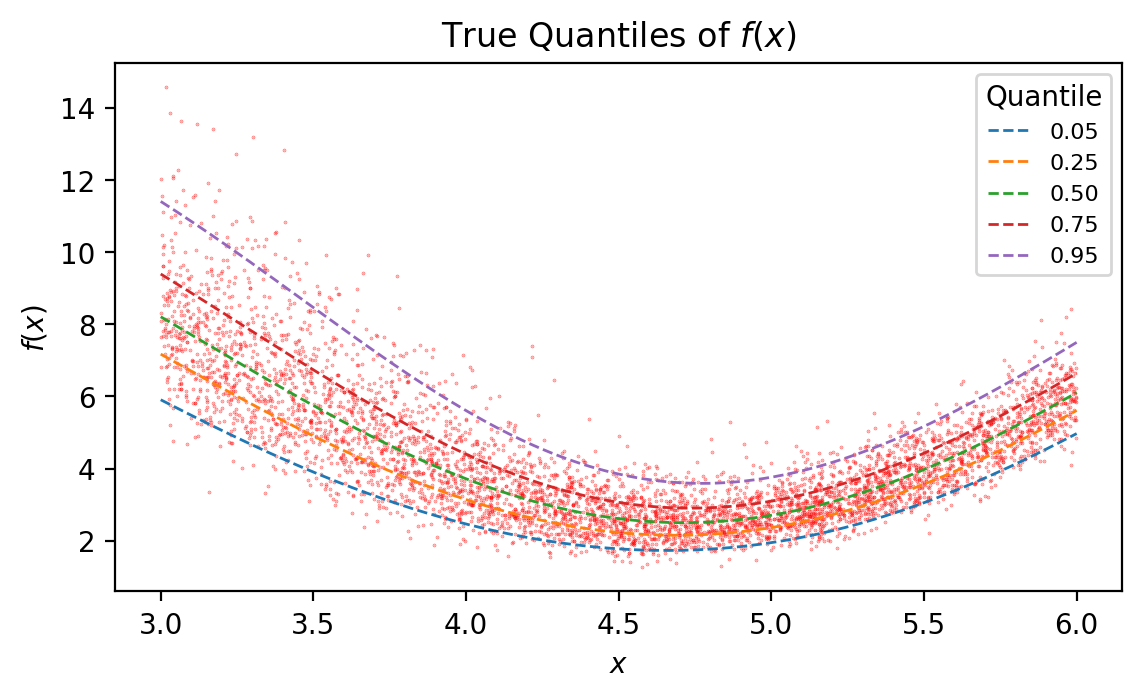

In [2]:
# generate random data
def e(x):
    """Compute lognormal sigma as a function of x."""
    return 1.0 / ((x - 4.0) ** 2 + 4.0)

np.random.seed(17)
x = np.random.uniform(3.0, 6.0, size=5000)
error = np.random.lognormal(mean=0.0, sigma=e(x))
y = (5.0 * np.sin(x) + 7.5) * error

# plot true quantiles
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(x, y, s=0.1, color="red", alpha=0.5)

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
xs = np.linspace(3.0, 6.0, 1001)
es = e(xs)
band_list = list()
for i, q in enumerate(quantiles):
    values = (5.0 * np.sin(xs) + 7.5) * scst.lognorm.ppf(q, es)
    band_list.append(values)
    ax.plot(xs, values, linestyle="--", linewidth=1.0, label=f"{q:0.2f}")

ax.legend(loc="best", title="Quantile", fontsize=8)
ax.set_ylabel("$f(x)$")
ax.set_xlabel("$x$")
ax.set_title("True Quantiles of $f(x)$");

### Specify different modeling algorithms

Parameters here are arbitrary. There is no tuning or CV performed.

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor

# create list of different model algorithm callbacks with some kwargs
# note: no tuning/CV has been done here
model_names = [
    "Neural Network",
    "Decision Tree",
    "Random Forest",
    "Gaussian Process",
    "KNeighbors Regressor",
]

model_list = [
    {
        "model_callback": MLPRegressor,
        "model_callback_kwargs": {"hidden_layer_sizes": (16, 8, 4),
                                  "max_iter": 1000,
                                  "alpha": 0.02,}
    },
    {
        "model_callback": DecisionTreeRegressor,
        "model_callback_kwargs": {"splitter": "random",
                                  "max_depth": 3,
                                  "min_samples_split": 25,}
    },
    {
        "model_callback": RandomForestRegressor,
        "model_callback_kwargs": {"n_estimators": 10,
                                  "min_samples_split": 30,
                                  "max_depth": 3,}
    },
    {
        "model_callback": GaussianProcessRegressor,
        "model_callback_kwargs": None
    },
    {
        "model_callback": KNeighborsRegressor,
        "model_callback_kwargs": {"n_neighbors": 100,}
    },
]

### Fit the model ensembles

In [4]:
# fit models
model_results_list = list()
for i, (q, kwargs) in enumerate(zip(quantiles, model_list)):
    print("Fitting ensemble of {:s} models...".format(model_names[i]))
    model = BoostedModel(
        link=IdentityLink(),
        loss=QuantileLoss(q),
        weights="none",
        alpha=0.2,
        step_type="constant",
        validation_fraction=0.15,
        validation_iter_stop=20,
        **kwargs
    )
    model.fit(x.reshape((-1, 1)), y, iterations=500)
    preds = model.predict(xs.reshape((-1, 1)))
    model_results_list.append((model, preds))

Fitting ensemble of Neural Network models...
Fitting ensemble of Decision Tree models...
Fitting ensemble of Random Forest models...
Fitting ensemble of Gaussian Process models...
Fitting ensemble of KNeighbors Regressor models...


### Plot the results

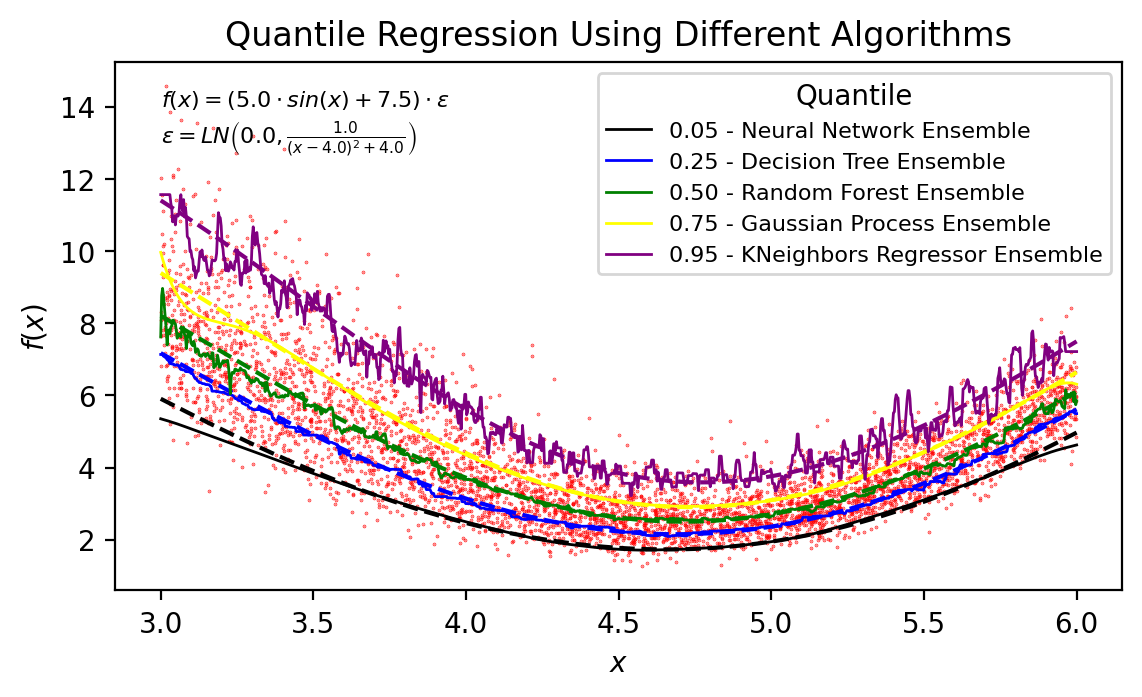

In [5]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(x, y, s=0.1, color="red", alpha=0.75)

colors = ["black", "blue", "green", "yellow", "purple"]
for i, (model, preds) in enumerate(model_results_list):
    q, model_name = quantiles[i], model_names[i]
    label = f"{q:0.02f} - {model_name} Ensemble"
    ax.plot(
        xs, band_list[i],
        color=colors[i],
        linestyle="--",
        label="__nolegend__"
    )
    ax.plot(xs, preds, color=colors[i], label=label, linewidth=1)
ax.legend(loc="best", title="Quantile", fontsize=8)
ax.set_ylabel("$f(x)$")
ax.set_xlabel("$x$")
ax.set_title("Quantile Regression Using Different Algorithms")
ax.text(3, 14,
        r"$f(x) = (5.0 \cdot sin(x) + 7.5) \cdot \epsilon$",
        fontsize=8,
)
ax.text(3, 13,
        r"$ \epsilon = LN \left( 0.0, \frac{1.0}{(x - 4.0)^2 + 4.0} \right) $",
        fontsize=8,
);

### Model Iterations

In [6]:
for i, (model, preds) in enumerate(model_results_list):
    print("{:s}: {:d} iterations".format(model_names[i], model.get_iterations()))

Neural Network: 310 iterations
Decision Tree: 96 iterations
Random Forest: 94 iterations
Gaussian Process: 95 iterations
KNeighbors Regressor: 170 iterations
